Selecting variants by number of unique barcodes
-------------------------------------------------------------

This notebook gets scores for the variants in an Experiment that are linked to multiple barcodes, and plots the relationship between each variant's score and number of unique barcodes.

In [2]:
% matplotlib inline

In [53]:
from __future__ import print_function
import os.path
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from enrich2.variant import WILD_TYPE_VARIANT
import enrich2.plots as enrich_plot
pd.set_option("display.max_rows", 10) # rows shown when pretty-printing

Modify the ``results_path`` variable in the next cell to match the output directory of your Enrich2-Example dataset.

In [4]:
results_path = "/path/to/Enrich2-Example/Results/"

Open the Experiment HDF5 file.

In [10]:
my_store = pd.HDFStore(os.path.join(results_path, "BRCA1_Example_exp.h5"))

The ``pd.HDFStore.keys()`` method returns a list of all the tables in this HDF5 file.

In [73]:
my_store.keys()

['/main/barcodemap',
 '/main/barcodes/counts',
 '/main/barcodes/scores',
 '/main/barcodes/scores_shared',
 '/main/barcodes/scores_shared_full',
 '/main/synonymous/counts',
 '/main/synonymous/scores',
 '/main/synonymous/scores_pvalues_wt',
 '/main/synonymous/scores_shared',
 '/main/synonymous/scores_shared_full',
 '/main/variants/counts',
 '/main/variants/scores',
 '/main/variants/scores_pvalues_wt',
 '/main/variants/scores_shared',
 '/main/variants/scores_shared_full']

First we will work with the barcode-variant map for this analysis, stored in the "/main/barcodemap" table. The index is the barcode and it has a single column for the variant HGVS string.

In [74]:
bcm = my_store['/main/barcodemap']
bcm

,value
TTTTTTGTGTCTGTGA,_wt
GGGCACGTCTTTATAG,_wt
GTTACTGGTTAGTATT,_wt
GTTACTTGATCCGACC,_wt
GTTAGATGGATGTACG,_wt
...,...
GAGTACTTTTTTGATT,"c.9T>C (p.=), c.62T>C (p.Leu21Ser), c.63A>T (p..."
ATGATGACGTGTCTTG,c.9T>G (p.=)
TCACCGGAACGTTGGT,c.9T>G (p.=)
TGACGATGTTGCATTT,"c.9T>G (p.=), c.17G>C (p.Arg6Pro), c.18C>T (p...."


To find out how many unique barcodes are linked to each variant, we'll count the number of times each variant appears in the barcode-variant map using a [Counter data structure](https://docs.python.org/2/library/collections.html#counter-objects). We'll then output the top ten variants by number of unique barcodes.

In [75]:
variant_bcs = Counter(bcm['value'])
variant_bcs.most_common(10)

[('_wt', 5844),
 ('c.63A>T (p.Leu21Phe)', 109),
 ('c.39C>A (p.=)', 91),
 ('c.61T>A (p.Leu21Ile), c.63A>T (p.Leu21Ile)', 77),
 ('c.62T>A (p.Leu21Tyr), c.63A>T (p.Leu21Tyr)', 77),
 ('c.63A>G (p.=)', 73),
 ('c.72C>A (p.=)', 72),
 ('c.62T>G (p.Leu21Cys), c.63A>T (p.Leu21Cys)', 71),
 ('c.13C>A (p.Leu5Ile)', 70),
 ('c.62T>A (p.Leu21Ter)', 63)]

Next we'll turn the Counter into a data frame.

In [76]:
bc_counts = pd.DataFrame(variant_bcs.most_common(), columns=['variant', 'barcodes'])
bc_counts

,variant,barcodes
0,_wt,5844
1,c.63A>T (p.Leu21Phe),109
2,c.39C>A (p.=),91
3,"c.61T>A (p.Leu21Ile), c.63A>T (p.Leu21Ile)",77
4,"c.62T>A (p.Leu21Tyr), c.63A>T (p.Leu21Tyr)",77
...,...,...
1958,"c.77G>T (p.Cys26Leu), c.78C>A (p.Cys26Leu), c....",1
1959,"c.67T>A (p.Cys23Ile), c.68G>T (p.Cys23Ile), c....",1
1960,"c.41T>C (p.Ile14Thr), c.48T>G (p.=)",1
1961,"c.55A>C (p.Lys19Leu), c.56A>T (p.Lys19Leu), c....",1


The data frame has the information we want, but it will be easier to use later if it's indexed by variant rather than row number.

In [77]:
bc_counts.index = bc_counts['variant']
bc_counts.index.name = None
del bc_counts['variant']
bc_counts

,barcodes
_wt,5844
c.63A>T (p.Leu21Phe),109
c.39C>A (p.=),91
"c.61T>A (p.Leu21Ile), c.63A>T (p.Leu21Ile)",77
"c.62T>A (p.Leu21Tyr), c.63A>T (p.Leu21Tyr)",77
...,...
"c.77G>T (p.Cys26Leu), c.78C>A (p.Cys26Leu), c.81G>T (p.=)",1
"c.67T>A (p.Cys23Ile), c.68G>T (p.Cys23Ile), c.69T>A (p.Cys23Ile)",1
"c.41T>C (p.Ile14Thr), c.48T>G (p.=)",1
"c.55A>C (p.Lys19Leu), c.56A>T (p.Lys19Leu), c.57A>G (p.Lys19Leu), c.81G>T (p.=)",1


We'll use a cutoff to choose variants with a minimum number of unique barcodes, and store this subset in a new index. We'll also exclude the wild type by dropping the first entry of the index.

In [78]:
bc_cutoff = 10

In [79]:
multi_bc_variants = bc_counts.loc[bc_counts['barcodes']  >= bc_cutoff].index[1:]
multi_bc_variants

Index([u'c.63A>T (p.Leu21Phe)', u'c.39C>A (p.=)',
       u'c.61T>A (p.Leu21Ile), c.63A>T (p.Leu21Ile)',
       u'c.62T>A (p.Leu21Tyr), c.63A>T (p.Leu21Tyr)', u'c.63A>G (p.=)',
       u'c.72C>A (p.=)', u'c.62T>G (p.Leu21Cys), c.63A>T (p.Leu21Cys)',
       u'c.13C>A (p.Leu5Ile)', u'c.62T>A (p.Leu21Ter)',
       u'c.63A>C (p.Leu21Phe)',
       ...
       u'c.88A>C (p.Ile30Arg), c.89T>G (p.Ile30Arg), c.90C>T (p.Ile30Arg)',
       u'c.76T>A (p.Cys26Lys), c.77G>A (p.Cys26Lys), c.78C>G (p.Cys26Lys)',
       u'c.22G>A (p.Glu8Ile), c.23A>T (p.Glu8Ile), c.24A>T (p.Glu8Ile)',
       u'c.49A>T (p.Met17Ser), c.50T>C (p.Met17Ser), c.51G>A (p.Met17Ser)',
       u'c.64G>A (p.Glu22Arg), c.65A>G (p.Glu22Arg)',
       u'c.77G>C (p.Cys26Ser), c.78C>G (p.Cys26Ser)',
       u'c.29T>A (p.Val10Glu), c.30A>G (p.Val10Glu)',
       u'c.50T>A (p.Met17Asn), c.51G>T (p.Met17Asn)',
       u'c.61T>A (p.Leu21Thr), c.62T>C (p.Leu21Thr), c.63A>G (p.Leu21Thr)',
       u'c.49A>G (p.Met17Ala), c.50T>C (p.Met17Ala)'],
     

We can use this index to get condition-level scores for these variants by querying the "/main/variants/scores" table. Since we are working with an Experiment HDF5 file, the data frame column names are a MultiIndex with two levels, one for experimental conditions and one for data values (see the [pandas documentation](http://pandas.pydata.org/pandas-docs/stable/advanced.html) for more information).

In [80]:
multi_bc_scores = my_store.select('/main/variants/scores', where='index in multi_bc_variants')
multi_bc_scores

condition                                              E3                 \
value                                                  SE        epsilon   
c.10G>A (p.Ala4Thr)                          1.435686e-01   3.469447e-18   
c.10G>T (p.Ala4Ser)                          1.456404e-29   2.087042e-57   
c.11C>A (p.Ala4Asp)                          5.309592e-01   1.110223e-16   
c.13C>A (p.Leu5Ile)                          1.333666e-01   0.000000e+00   
c.13C>A (p.Leu5Ser), c.14T>G (p.Leu5Ser)     3.612046e-01   2.775558e-17   
...                                                   ...            ...   
c.89T>G (p.Ile30Ser), c.90C>T (p.Ile30Ser)   6.069463e-01   0.000000e+00   
c.8C>A (p.Ser3Tyr)                           3.785724e-01   2.775558e-17   
c.8C>T (p.Ser3Phe)                           8.669053e-02   2.602085e-18   
c.90C>A (p.=)                                9.681631e-02   5.204170e-18   
c.90C>T (p.=)                               5.450037e-117  8.793373e-229   

condition                                             
value                                          score  
c.10G>A (p.Ala4Thr)                        -0.238174  
c.10G>T (p.Ala4Ser)                        -0.177983  
c.11C>A (p.Ala4Asp)                         0.027898  
c.13C>A (p.Leu5Ile)                        -0.623652  
c.13C>A (p.Leu5Ser), c.14T>G (p.Leu5Ser)    0.657916  
...                                              ...  
c.89T>G (p.Ile30Ser), c.90C>T (p.Ile30Ser) -0.826140  
c.8C>A (p.Ser3Tyr)                         -1.440477  
c.8C>T (p.Ser3Phe)                         -0.091250  
c.90C>A (p.=)                              -0.217977  
c.90C>T (p.=)                               0.805631  

[486 rows x 3 columns]

There are fewer rows in ``multi_bc_scores`` than in ``multi_bc_variants`` because some of the variants were not scored in all replicate selections, and therefore do not have a condition-level score.

Now that we're finished getting data out of the HDF5 file, we'll close it.

In [81]:
my_store.close()

We'll add a column to the ``bc_counts`` data frame that contains scores from the ``multi_bc_scores`` data frame. To reference a column in a data frame with a MultiIndex, we need to specify all column levels.

In [82]:
bc_counts['score'] = multi_bc_scores['E3', 'score']
bc_counts

,barcodes,score
_wt,5844,NaN
c.63A>T (p.Leu21Phe),109,1.387659
c.39C>A (p.=),91,-0.189253
"c.61T>A (p.Leu21Ile), c.63A>T (p.Leu21Ile)",77,-1.031977
"c.62T>A (p.Leu21Tyr), c.63A>T (p.Leu21Tyr)",77,0.310854
...,...,...
"c.77G>T (p.Cys26Leu), c.78C>A (p.Cys26Leu), c.81G>T (p.=)",1,NaN
"c.67T>A (p.Cys23Ile), c.68G>T (p.Cys23Ile), c.69T>A (p.Cys23Ile)",1,NaN
"c.41T>C (p.Ile14Thr), c.48T>G (p.=)",1,NaN
"c.55A>C (p.Lys19Leu), c.56A>T (p.Lys19Leu), c.57A>G (p.Lys19Leu), c.81G>T (p.=)",1,NaN


Many rows in ``bc_counts`` are missing scores (displayed as NaN) because those variants were not in ``multi_bc_scores``. We'll drop them before continuing.

In [83]:
bc_counts.dropna(inplace=True)
bc_counts

,barcodes,score
c.63A>T (p.Leu21Phe),109,1.387659
c.39C>A (p.=),91,-0.189253
"c.61T>A (p.Leu21Ile), c.63A>T (p.Leu21Ile)",77,-1.031977
"c.62T>A (p.Leu21Tyr), c.63A>T (p.Leu21Tyr)",77,0.310854
c.63A>G (p.=),73,-0.406277
...,...,...
"c.64G>A (p.Glu22Arg), c.65A>G (p.Glu22Arg)",10,-2.577200
"c.77G>C (p.Cys26Ser), c.78C>G (p.Cys26Ser)",10,-3.497939
"c.50T>A (p.Met17Asn), c.51G>T (p.Met17Asn)",10,-1.737378
"c.61T>A (p.Leu21Thr), c.62T>C (p.Leu21Thr), c.63A>G (p.Leu21Thr)",10,-1.307432


Now that we have a data frame containing the subset of variants we're interested in, we can make a plot of score vs. number of unique barcodes. This example uses functions and colors from the Enrich2 plotting library. 

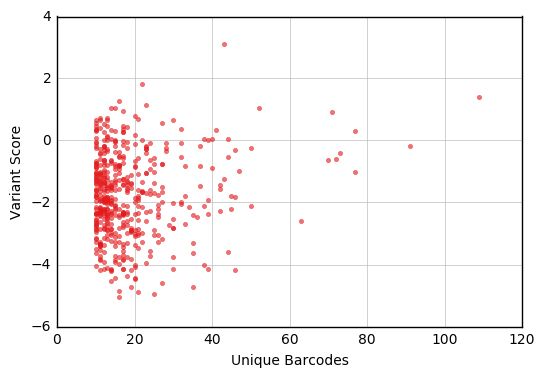

In [86]:
fig, ax = plt.subplots()
enrich_plot.configure_axes(ax, xgrid=True)
ax.plot(bc_counts['barcodes'], 
        bc_counts['score'], 
        linestyle='none', marker='.', alpha=0.6,
        color=enrich_plot.plot_colors['bright5'])
ax.set_xlabel("Unique Barcodes")
ax.set_ylabel("Variant Score")